In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from collections import defaultdict,Counter
from rdkit.Chem import AllChem
import pickle

from ChemTopicModel import chemTopicModel, drawTopicModel

import sklearn
from rdkit import rdBase
import matplotlib as mpl

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Seaborn version',sns.__version__)

RDKit version:  2018.09.2
Pandas version: 0.24.1
Scikit-Learn version: 0.20.2
Numpy version: 1.16.2
MatplotLib version: 3.0.2
Seaborn version 0.9.0


In [2]:
%matplotlib inline

### Load the topic model for ChEMBL23

Model was created with the following script/command:

python runTopicModel.py --data chembl23_mols.csv.shuffled --rareThres 0.0005 --njobsFrag 10 --numTopics 100 --sizeSampleDataSet 0.1 --outfilePrefix tm_chembl23_100 --maxIterOpt 50 --chunksize 85000 --lowPrec 1

In [3]:
with open('../tm_chembl23_100.pkl', 'rb') as fp:
     chemblTopicModel = pickle.load(fp)

In [4]:
chemblTopicModel.fragM.shape

(1647380, 5132)

Find molecules without features

In [5]:
np.where(chemblTopicModel.fragM.sum(axis=1) == 0)[0].shape

(11733,)

In [6]:
11733.0/1647380

0.007122218310286637

### Calculate the different metrics to explore the topic model in more detail

In [7]:
numDocs, numTopics = chemblTopicModel.documentTopicProbabilities.shape

In [8]:
numTopicsMol=[]
for i in range(numDocs):
    numTopicsMol.append(len(Counter(chemblTopicModel.documentTopicProbabilities[i]))-1)

In [9]:
numAtoms=[]
for i in range(numDocs):
    numAtoms.append(Chem.MolFromSmiles(chemblTopicModel.moldata['smiles'][i]).GetNumAtoms())

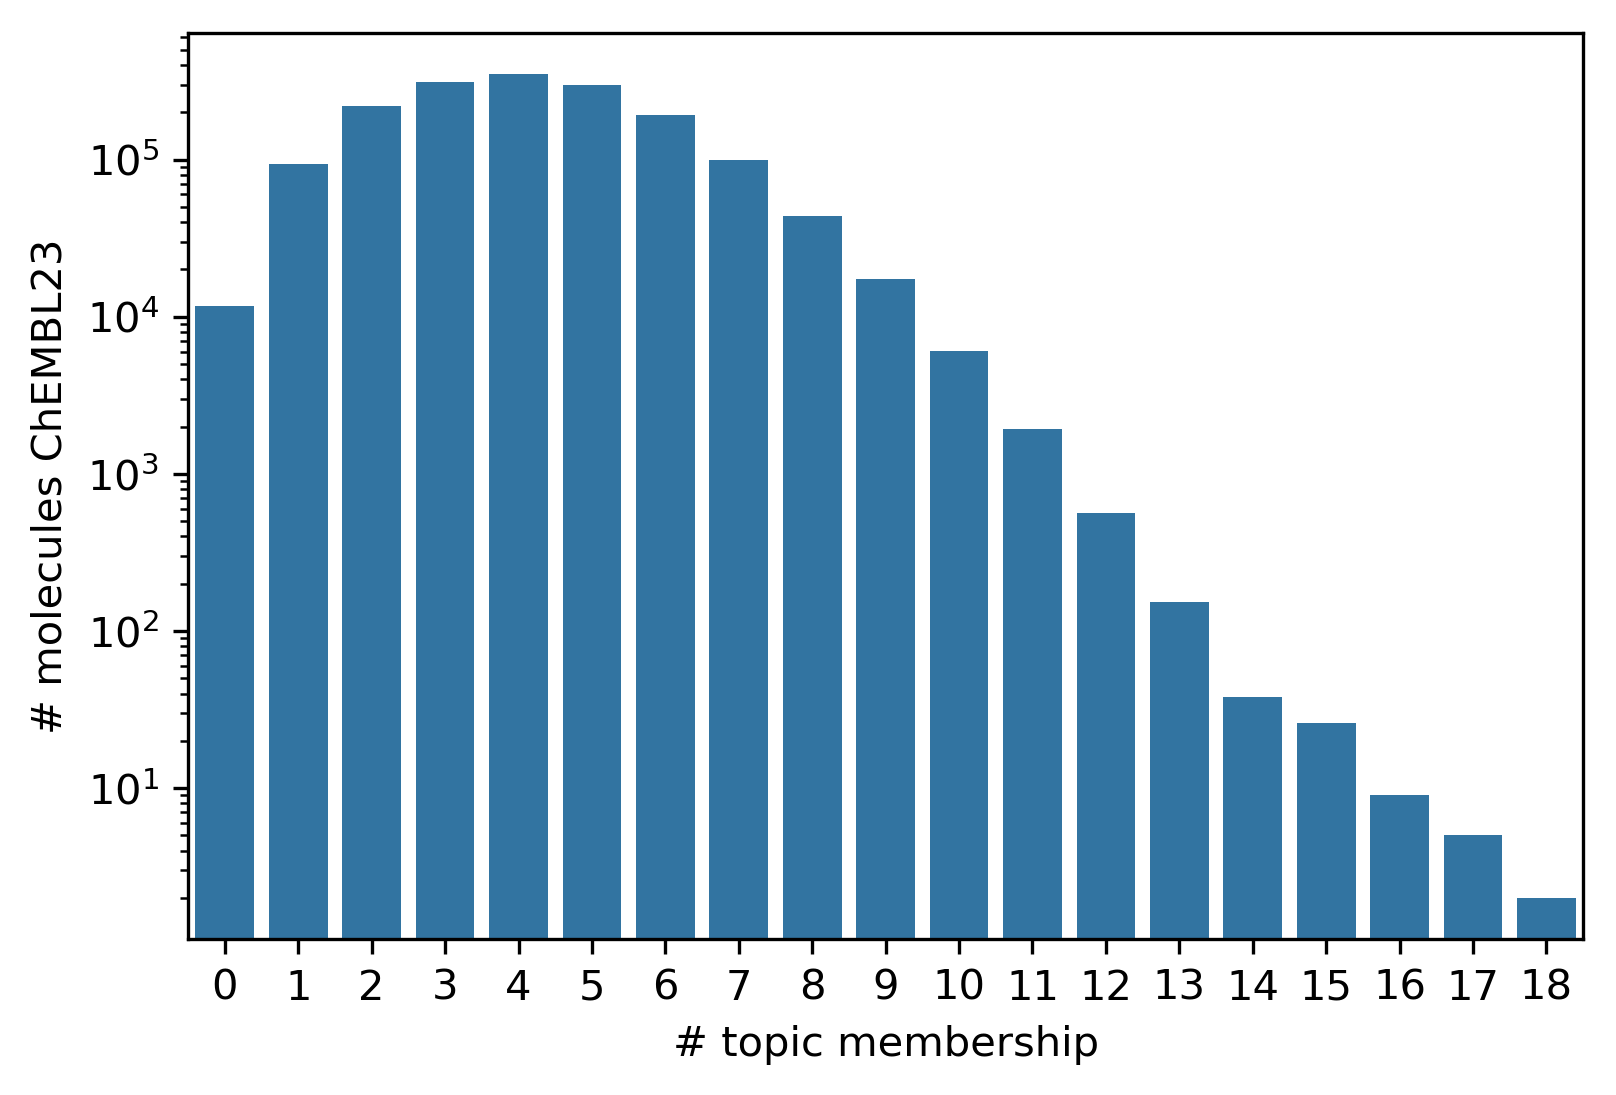

In [10]:
fig, ax = plt.subplots(1, dpi=300,)
sns.countplot(numTopicsMol, color=sns.color_palette()[0], ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# molecules ChEMBL23')
ax.set_xlabel('# topic membership');
# fig.savefig('TopicMembershipChEMBL23.png', dpi=300, bbox_inches='tight')

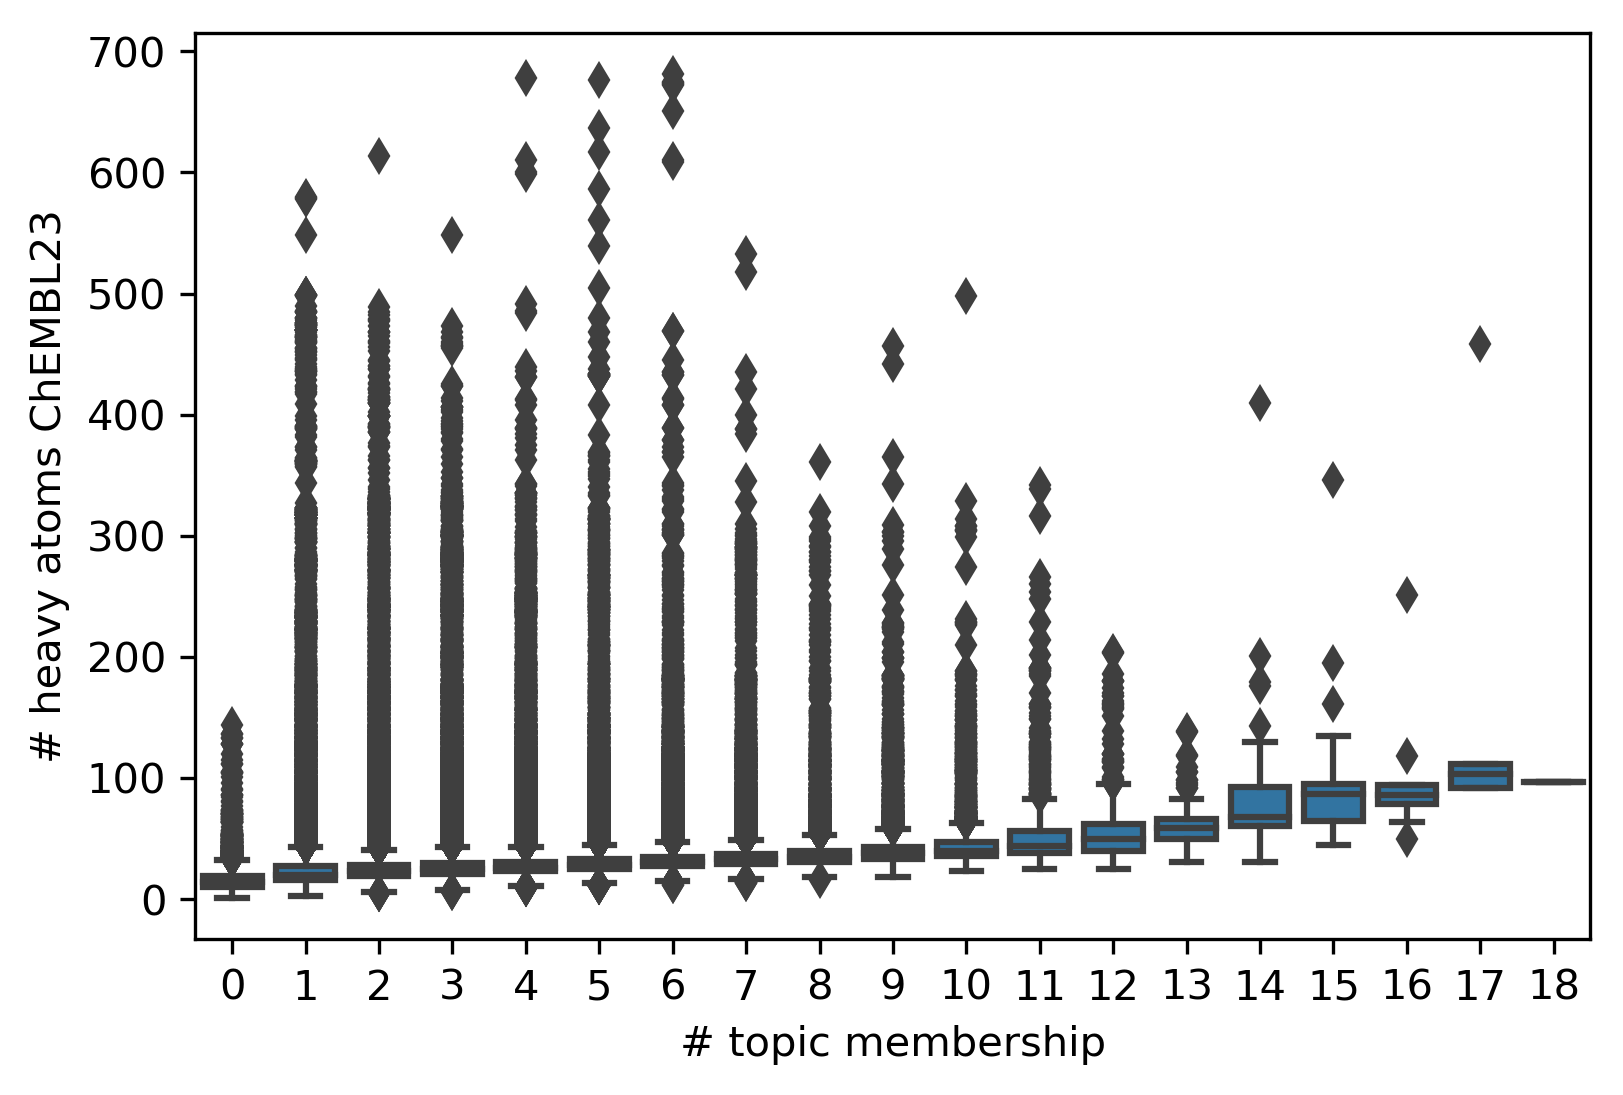

In [11]:
fig, ax = plt.subplots(1, dpi=300,)
sns.boxplot(numTopicsMol,numAtoms,color=sns.color_palette()[0], ax=ax)
ax.set_ylabel('# heavy atoms ChEMBL23')
ax.set_xlabel('# topic membership');
# fig.savefig('TopicMembershipVsNumAtomsChEMBL23.png', dpi=300, bbox_inches='tight')

In [12]:
from ChemTopicModel import utilsChemTM

In [13]:
ranking_result = utilsChemTM.rankInterestingTopics(chemblTopicModel, topXfrags=5)

In [14]:
ranking_result = ranking_result.sort_values(['fraction high prob. mols'], ascending=False).reset_index(drop=True)

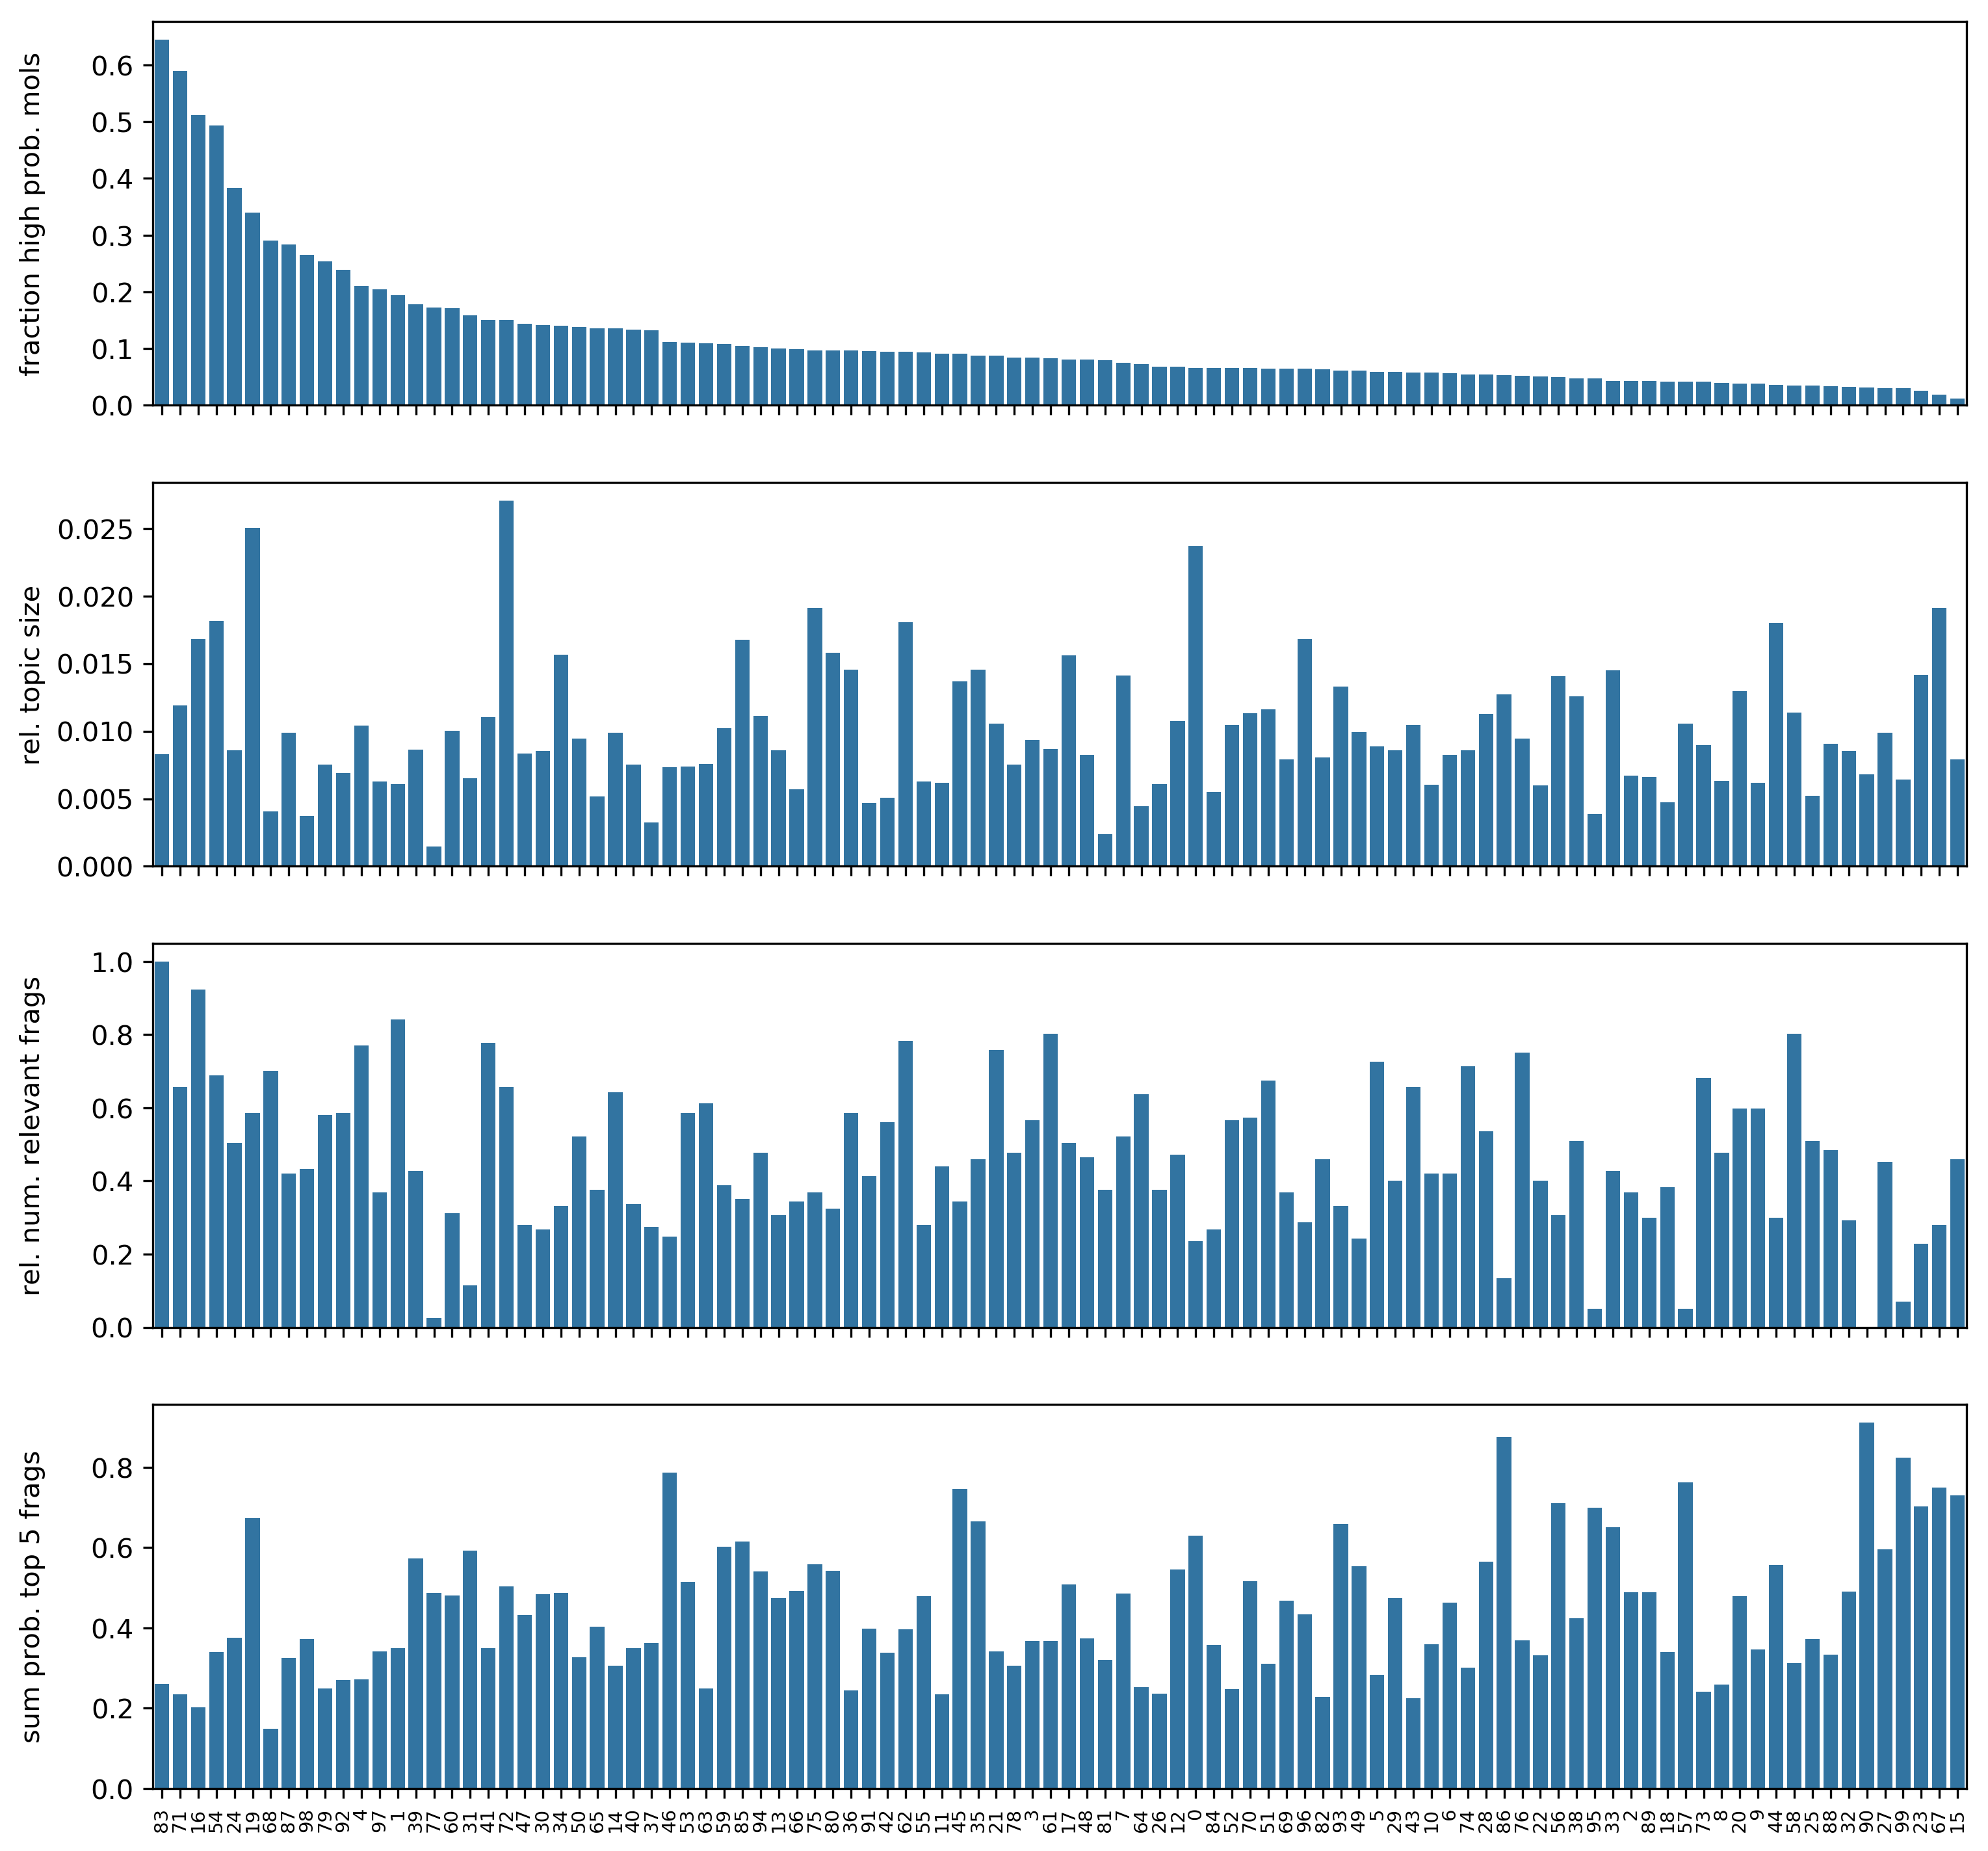

In [15]:
fig,ax=plt.subplots(4,1, figsize=(12,12),dpi=300)
sns.barplot(x=list(range(100)),y=ranking_result['fraction high prob. mols'],color=sns.color_palette()[0], ax=ax[0])
sns.barplot(x=list(range(100)),y=ranking_result['rel. topic size'],color=sns.color_palette()[0], ax=ax[1])
sns.barplot(x=list(range(100)),y=ranking_result['rel. num. relevant frags'],color=sns.color_palette()[0], ax=ax[2])
sns.barplot(x=list(range(100)),y=ranking_result['sum prob. top 5 frags'],color=sns.color_palette()[0], ax=ax[3])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)

_=ax[3].set_xticklabels(ranking_result['Topic Idx'],rotation=90,fontsize=7,verticalalignment='top')
fig.align_ylabels(ax)
# fig.savefig('TopicRankingChEMBL23.png', dpi=300, bbox_inches='tight')

In [16]:
ranking_result[:8]

,Topic Idx,fraction high prob. mols,abs. topic size,rel. topic size,rel. num. relevant frags,sum prob. top 5 frags
0,83,0.645027,13663,0.008294,1.000000,0.261093
1,71,0.590063,19603,0.011900,0.656051,0.234303
2,16,0.511488,27682,0.016804,0.923567,0.201310
3,54,0.492991,29891,0.018145,0.687898,0.340047
4,24,0.383571,14146,0.008587,0.503185,0.375710
5,19,0.340180,41234,0.025030,0.585987,0.673773
6,68,0.290879,6721,0.004080,0.700637,0.148126
7,87,0.283155,16242,0.009859,0.420382,0.324340


### Look at the topics with the highest number of highly probable molecules

In [17]:
for idx in ranking_result['Topic Idx'][:8]:
    drawTopicModel.drawFragmentsbyTopic(chemblTopicModel, idx, n_top_frags=8, numRowsShown=2.5,numColumns=8)
#     drawTopicModel.drawMolsByTopic(chemblTopicModel, idx, idsLabelToShow=[1,2], baseRad=0.9, color=(0.6,0.8,0.9), maxMols=4,
#                                    topicProbThreshold=0.5, maxTopicProb=0.5)

p(k=16)=0.05,p(k=16)=0.04,p(k=16)=0.04,p(k=16)=0.04,p(k=16)=0.04,p(k=16)=0.03,p(k=16)=0.03,p(k=16)=0.03


\n \n\n\n\n\n\n\n*\n*\n,\n \n\n\n\n\n*\n,\n \n\n\n\n\n\n*\n,\n \n\n\n\n\n\n\n\n\n*\n*\n*\n,\n \n\n\n\n\n\n\n\nO\n*\n*\n,\n \n\n\n\n\n\n\n\n\n\n\n\nNH\n*\n*\nO\n,\n \n\n\n\n\n\n\n\n\n\n\n\n\n*\n*\n*\nO\n,\n \n\n\n\n\n\n\n\n\n\n\n*\n*\n*\n
p(k=19)=0.42,p(k=19)=0.10,p(k=19)=0.07,p(k=19)=0.05,p(k=19)=0.03,p(k=19)=0.03,p(k=19)=0.02,p(k=19)=0.02


p(k=87)=0.13,p(k=87)=0.07,p(k=87)=0.04,p(k=87)=0.04,p(k=87)=0.04,p(k=87)=0.04,p(k=87)=0.03,p(k=87)=0.03


### Store some topics for further investigation

In [18]:
def prepareSubsets(TM, tidx):
    subTopic = np.where(TM.documentTopicProbabilities.argmax(axis=1) == tidx)
    subTopicData = chemblTopicModel.moldata.iloc[subTopic]
    subTopicData = subTopicData[['smiles', 'label_1', 'label_2']]
    subTopicData.rename({'label_1':'docIds', 'label_2':'ChemblID'}, inplace=True)
    subTopicData.reset_index(inplace=True, drop=True)
    return subTopicData

In [19]:
def prepareNonFitSubset(TM):
    subTopic = np.where(TM.fragM.sum(axis=1) == 0)[0]
    subTopicData = chemblTopicModel.moldata.iloc[subTopic]
    subTopicData = subTopicData[['smiles', 'label_1', 'label_2']]
    subTopicData.rename({'label_1':'docIds', 'label_2':'ChemblID'}, inplace=True)
    subTopicData.reset_index(inplace=True, drop=True)
    return subTopicData

In [20]:
data61 = prepareSubsets(chemblTopicModel, 61)

In [21]:
# data61.to_csv('TMChembl23_61subtopic.csv', index=False)

In [22]:
nonFit = prepareNonFitSubset(chemblTopicModel)

In [23]:
nonFit.shape

(11733, 3)

In [24]:
# nonFit.to_csv('TMChembl23_NonFitMols.csv', index=False)